In [1]:
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import functools
%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 22

from parse_player_stats import ROLES, ROLES_LISTS

DATA_PATH = "test_train/"

In [68]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
tank_train = pd.read_csv(DATA_PATH + "tank_train.csv")
tank_test = pd.read_csv(DATA_PATH + "tank_test.csv")
damage_train = pd.read_csv(DATA_PATH + "damage_train.csv")
damage_test = pd.read_csv(DATA_PATH + "damage_test.csv")
support_train = pd.read_csv(DATA_PATH + "support_train.csv")
support_test = pd.read_csv(DATA_PATH + "support_test.csv")

train_lst = {"tank": tank_train, "damage": damage_train, "support": support_train}
test_lst = {"tank": tank_test, "damage": damage_test, "support": support_test}

In [3]:
def simplest_preprocess(role="tank"):
    df = train_lst[role]
    y_train = df.rating.copy()
    X_train = df.drop('rating', axis=1)

    df_test = test_lst[role]
    y_test = df_test['rating']
    X_test = df_test.drop('rating', axis = 1)
    
    X_train = X_train.fillna(X_train.min(axis=0))
    X_test = X_test.fillna(X_train.min(axis=0))
    
    return X_train, y_train, X_test, y_test

In [5]:
def simplest_rf(X_train, y_train, X_test, y_test):    
    rf = RandomForestRegressor(random_state = 69)
    rf.fit(X_train, y_train)
    
    pred = rf.predict(X_test)
    rf_mse = metrics.mean_squared_error(y_test, pred)
    
    return rf, rf_mse, pred

In [6]:
def simplest_gb(X_train, y_train, X_test, y_test):
    gb = GradientBoostingRegressor(random_state = 69)
    gb.fit(X_train, y_train)
    
    pred = gb.predict(X_test)
    gb_mse = metrics.mean_squared_error(y_test, pred)
    
    return gb, gb_mse, pred

In [53]:
def cv_gb(X_train, y_train, X_test, y_test, grid, n_iter=100):
    gb = GradientBoostingRegressor(random_state = 69)
    gb_random = RandomizedSearchCV(estimator = gb, param_distributions = grid, n_iter = n_iter, cv = 5, verbose = 5, random_state = 69, n_jobs = -1)
    gb_random.fit(X_train, y_train)
    pred = gb_random.predict(X_test)
    gb_best_params = gb_random.best_params_
    gb_mse = metrics.mean_squared_error(y_test, pred)
    print("Best parameters for Gradient Boosting: ", gb_best_params)
    print("Mean Squared Error for Gradient Boosting = ", gb_mse)

    return gb_random.best_estimator_, gb_mse, pred

In [4]:
X_tr, y_tr, X_t, y_t = {}, {}, {}, {}
for role in ROLES:
    X_tr[role], y_tr[role], X_t[role], y_t[role] = simplest_preprocess(role)

In [204]:
%%time

best_models, mse_test_scores = {}, {}

# Random forest
for role in ROLES:
    curr_model, curr_score = simplest_rf(X_tr[role], y_tr[role], X_t[role], y_t[role])
    best_models[role] = curr_model
    mse_test_scores[role] = curr_score
    print(f"RF MSE score for {role} is {curr_score}")

RF MSE score for tank is 182328.26498687037
RF MSE score for damage is 211625.98637231076
RF MSE score for support is 195863.36774309477
Wall time: 2min 51s


In [249]:
%%time

gb_best_models, gb_mse_test_scores, gb_predictions = {}, {}, {}

# Gradient Boosting
for role in ROLES:
    curr_model, curr_score, curr_prediction = simplest_gb(X_tr[role], y_tr[role], X_t[role], y_t[role])
    gb_best_models[role] = curr_model
    gb_mse_test_scores[role] = curr_score
    gb_predictions[role] = curr_prediction
    print(f"GB MSE score for {role} is {curr_score}")

GB MSE score for tank is 222208.47916727228
GB MSE score for damage is 267790.0079101204
GB MSE score for support is 235340.63294193664
Wall time: 35.4 s


In [52]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 8)]
learning_rate = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 1]
max_features = ['auto', 'sqrt']
max_depth = list(range(3, 17, 2))
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
gb_random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate       
              }

In [62]:
%%time

cvgb_best_models, cvgb_mse_test_scores, cvgb_predictions = {}, {}, {}

# CV Gradient Boosting
for role in ROLES:
    curr_model, curr_score, curr_prediction = cv_gb(X_tr[role], y_tr[role], X_t[role], y_t[role], gb_random_grid, n_iter=75)
    cvgb_best_models[role] = curr_model
    cvgb_mse_test_scores[role] = curr_score
    cvgb_predictions[role] = curr_prediction
    print(f"CV GB MSE score for {role} is {curr_score}")

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 38.8min finished


Best parameters for Gradient Boosting:  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 9, 'learning_rate': 0.05}
Mean Squared Error for Gradient Boosting =  177569.35918675203
CV GB MSE score for tank is 177569.35918675203
Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 54.5min finished


Best parameters for Gradient Boosting:  {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'learning_rate': 0.1}
Mean Squared Error for Gradient Boosting =  202794.21253058407
CV GB MSE score for damage is 202794.21253058407
Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 41.0min finished


Best parameters for Gradient Boosting:  {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'learning_rate': 0.1}
Mean Squared Error for Gradient Boosting =  186349.7753615899
CV GB MSE score for support is 186349.7753615899
Wall time: 2h 14min 59s


In [66]:
for role in ROLES:
    print(f"CV GB MSE score for {role} is {int(cvgb_mse_test_scores[role])}")

CV GB MSE score for tank is 177569
CV GB MSE score for damage is 202794
CV GB MSE score for support is 186349


In [214]:
role = "tank"
tank_predict = best_models[role].predict(X_t[role])

In [220]:
tank_predict.min()

991.6

In [221]:
y_t[role].values.min()

500.0

Text(0.5, 1.0, 'Tank, RF')

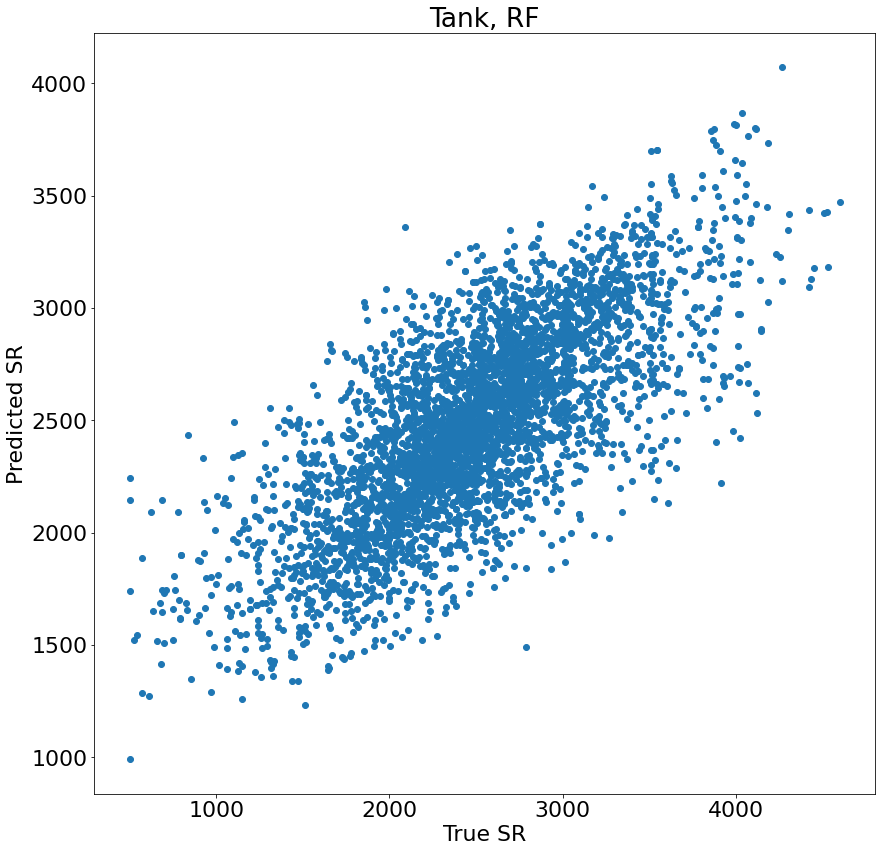

In [246]:
plt.figure(figsize = (14, 14))
plt.scatter(y_t[role].values, tank_predict)
plt.xlabel("True SR")
plt.ylabel("Predicted SR")
plt.title("Tank, RF")

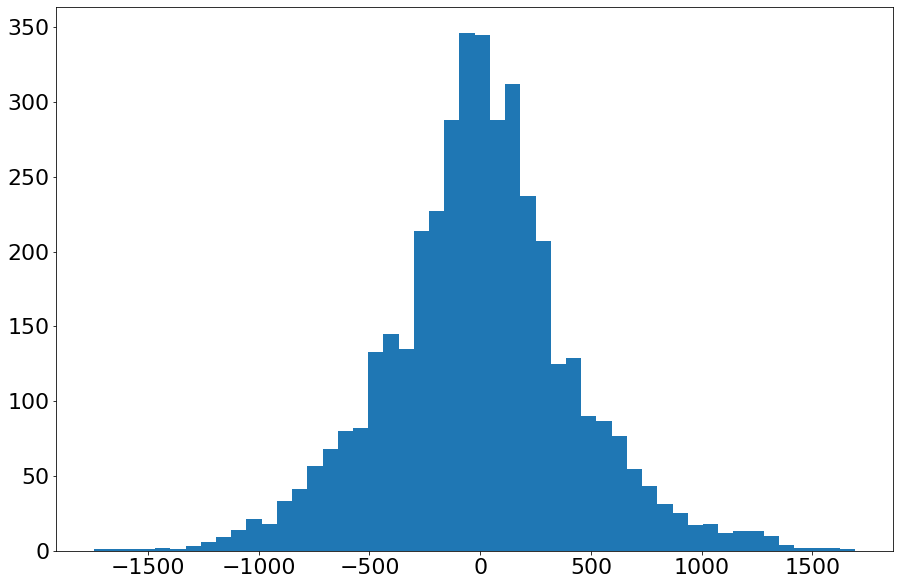

In [239]:
plt.hist(y_t[role].values -  tank_predict, bins=50);

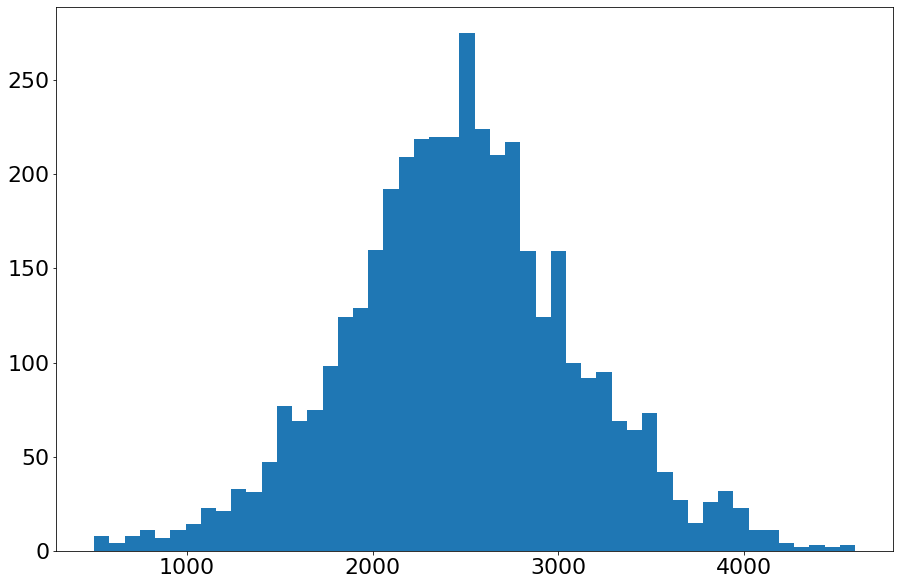

In [240]:
plt.hist(y_t[role].values, bins=50);

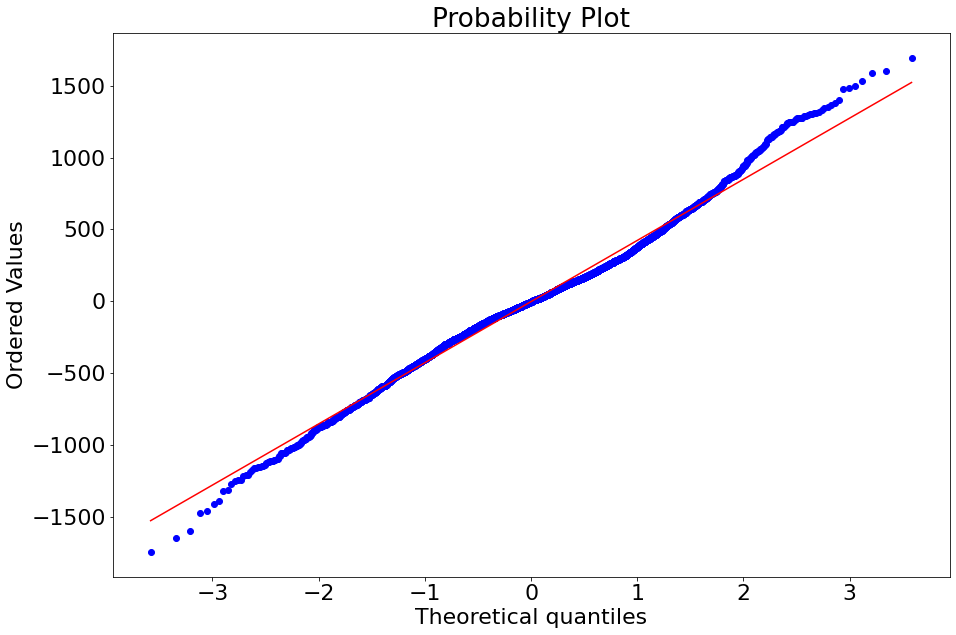

In [233]:
import scipy.stats as stats

import pylab 
stats.probplot(y_t[role].values -  tank_predict, dist="norm", plot=pylab);

# Aggregated

In [6]:
tank_train_X = pickle.load(open("aggregated/tank_train_X.pickle", "rb")) 
tank_train_y = pickle.load(open("aggregated/tank_train_y.pickle", "rb")) 
tank_test_X = pickle.load(open("aggregated/tank_test_X.pickle", "rb")) 
tank_test_y = pickle.load(open("aggregated/tank_test_y.pickle", "rb")) 

In [7]:
tank_train_X

,barrierDamageDoneAvgPer10Min,deathsAvgPer10Min,eliminationsAvgPer10Min,finalBlowsAvgPer10Min,heroDamageDoneAvgPer10Min,objectiveKillsAvgPer10Min,objectiveTimeAvgPer10Min,soloKillsAvgPer10Min,timeSpentOnFireAvgPer10Min,weaponAccuracy
0,2689.400000,6.696000,20.850000,8.804000,7276.200000,8.890000,108.000000,1.080000,55.200000,0.383333
1,4863.666667,4.753333,25.616667,10.070000,8841.000000,9.793333,85.000000,1.523333,84.666667,0.385000
2,3055.000000,6.430000,13.210000,6.610000,6740.000000,3.750000,50.000000,0.620000,14.000000,0.000000
3,4072.000000,7.340000,21.390000,7.400000,6794.000000,10.160000,97.000000,0.880000,44.000000,0.430000
4,4732.666667,5.613333,29.953333,12.606667,10274.666667,10.656667,73.333333,1.806667,124.333333,0.380000
...,...,...,...,...,...,...,...,...,...,...
16283,3525.000000,5.700000,20.480000,8.040000,7572.000000,7.590000,79.000000,0.570000,40.000000,0.300000
16284,2408.000000,9.140000,19.880000,11.680000,9114.000000,5.950000,100.000000,1.100000,103.000000,0.000000
16285,4178.500000,4.831667,23.465000,9.425000,7950.000000,8.471667,86.166667,1.658333,78.666667,0.370000
16286,3990.000000,7.345000,17.115000,8.595000,6902.500000,6.135000,71.500000,1.210000,35.000000,0.250000


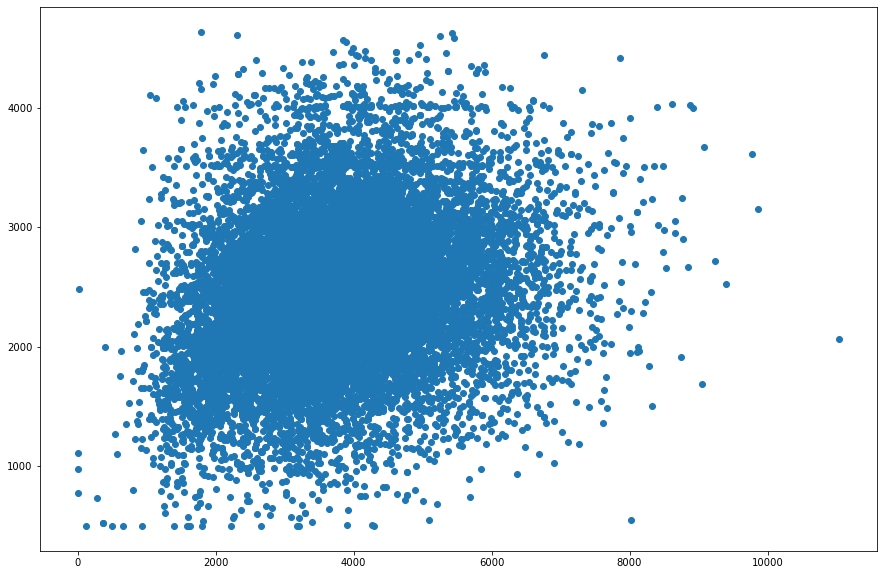

In [11]:
plt.scatter(tank_train_X.barrierDamageDoneAvgPer10Min, tank_train_y)

In [12]:
agg_df = tank_train_X.copy()

In [14]:
agg_df['rating'] = tank_train_y

In [15]:
agg_df.

,barrierDamageDoneAvgPer10Min,deathsAvgPer10Min,eliminationsAvgPer10Min,finalBlowsAvgPer10Min,heroDamageDoneAvgPer10Min,objectiveKillsAvgPer10Min,objectiveTimeAvgPer10Min,soloKillsAvgPer10Min,timeSpentOnFireAvgPer10Min,weaponAccuracy,rating
0,2689.400000,6.696000,20.850000,8.804000,7276.200000,8.890000,108.000000,1.080000,55.200000,0.383333,2247.0
1,4863.666667,4.753333,25.616667,10.070000,8841.000000,9.793333,85.000000,1.523333,84.666667,0.385000,1639.0
2,3055.000000,6.430000,13.210000,6.610000,6740.000000,3.750000,50.000000,0.620000,14.000000,0.000000,3115.0
3,4072.000000,7.340000,21.390000,7.400000,6794.000000,10.160000,97.000000,0.880000,44.000000,0.430000,2015.0
4,4732.666667,5.613333,29.953333,12.606667,10274.666667,10.656667,73.333333,1.806667,124.333333,0.380000,3358.0
...,...,...,...,...,...,...,...,...,...,...,...
16283,3525.000000,5.700000,20.480000,8.040000,7572.000000,7.590000,79.000000,0.570000,40.000000,0.300000,2641.0
16284,2408.000000,9.140000,19.880000,11.680000,9114.000000,5.950000,100.000000,1.100000,103.000000,0.000000,2604.0
16285,4178.500000,4.831667,23.465000,9.425000,7950.000000,8.471667,86.166667,1.658333,78.666667,0.370000,2805.0
16286,3990.000000,7.345000,17.115000,8.595000,6902.500000,6.135000,71.500000,1.210000,35.000000,0.250000,1969.0


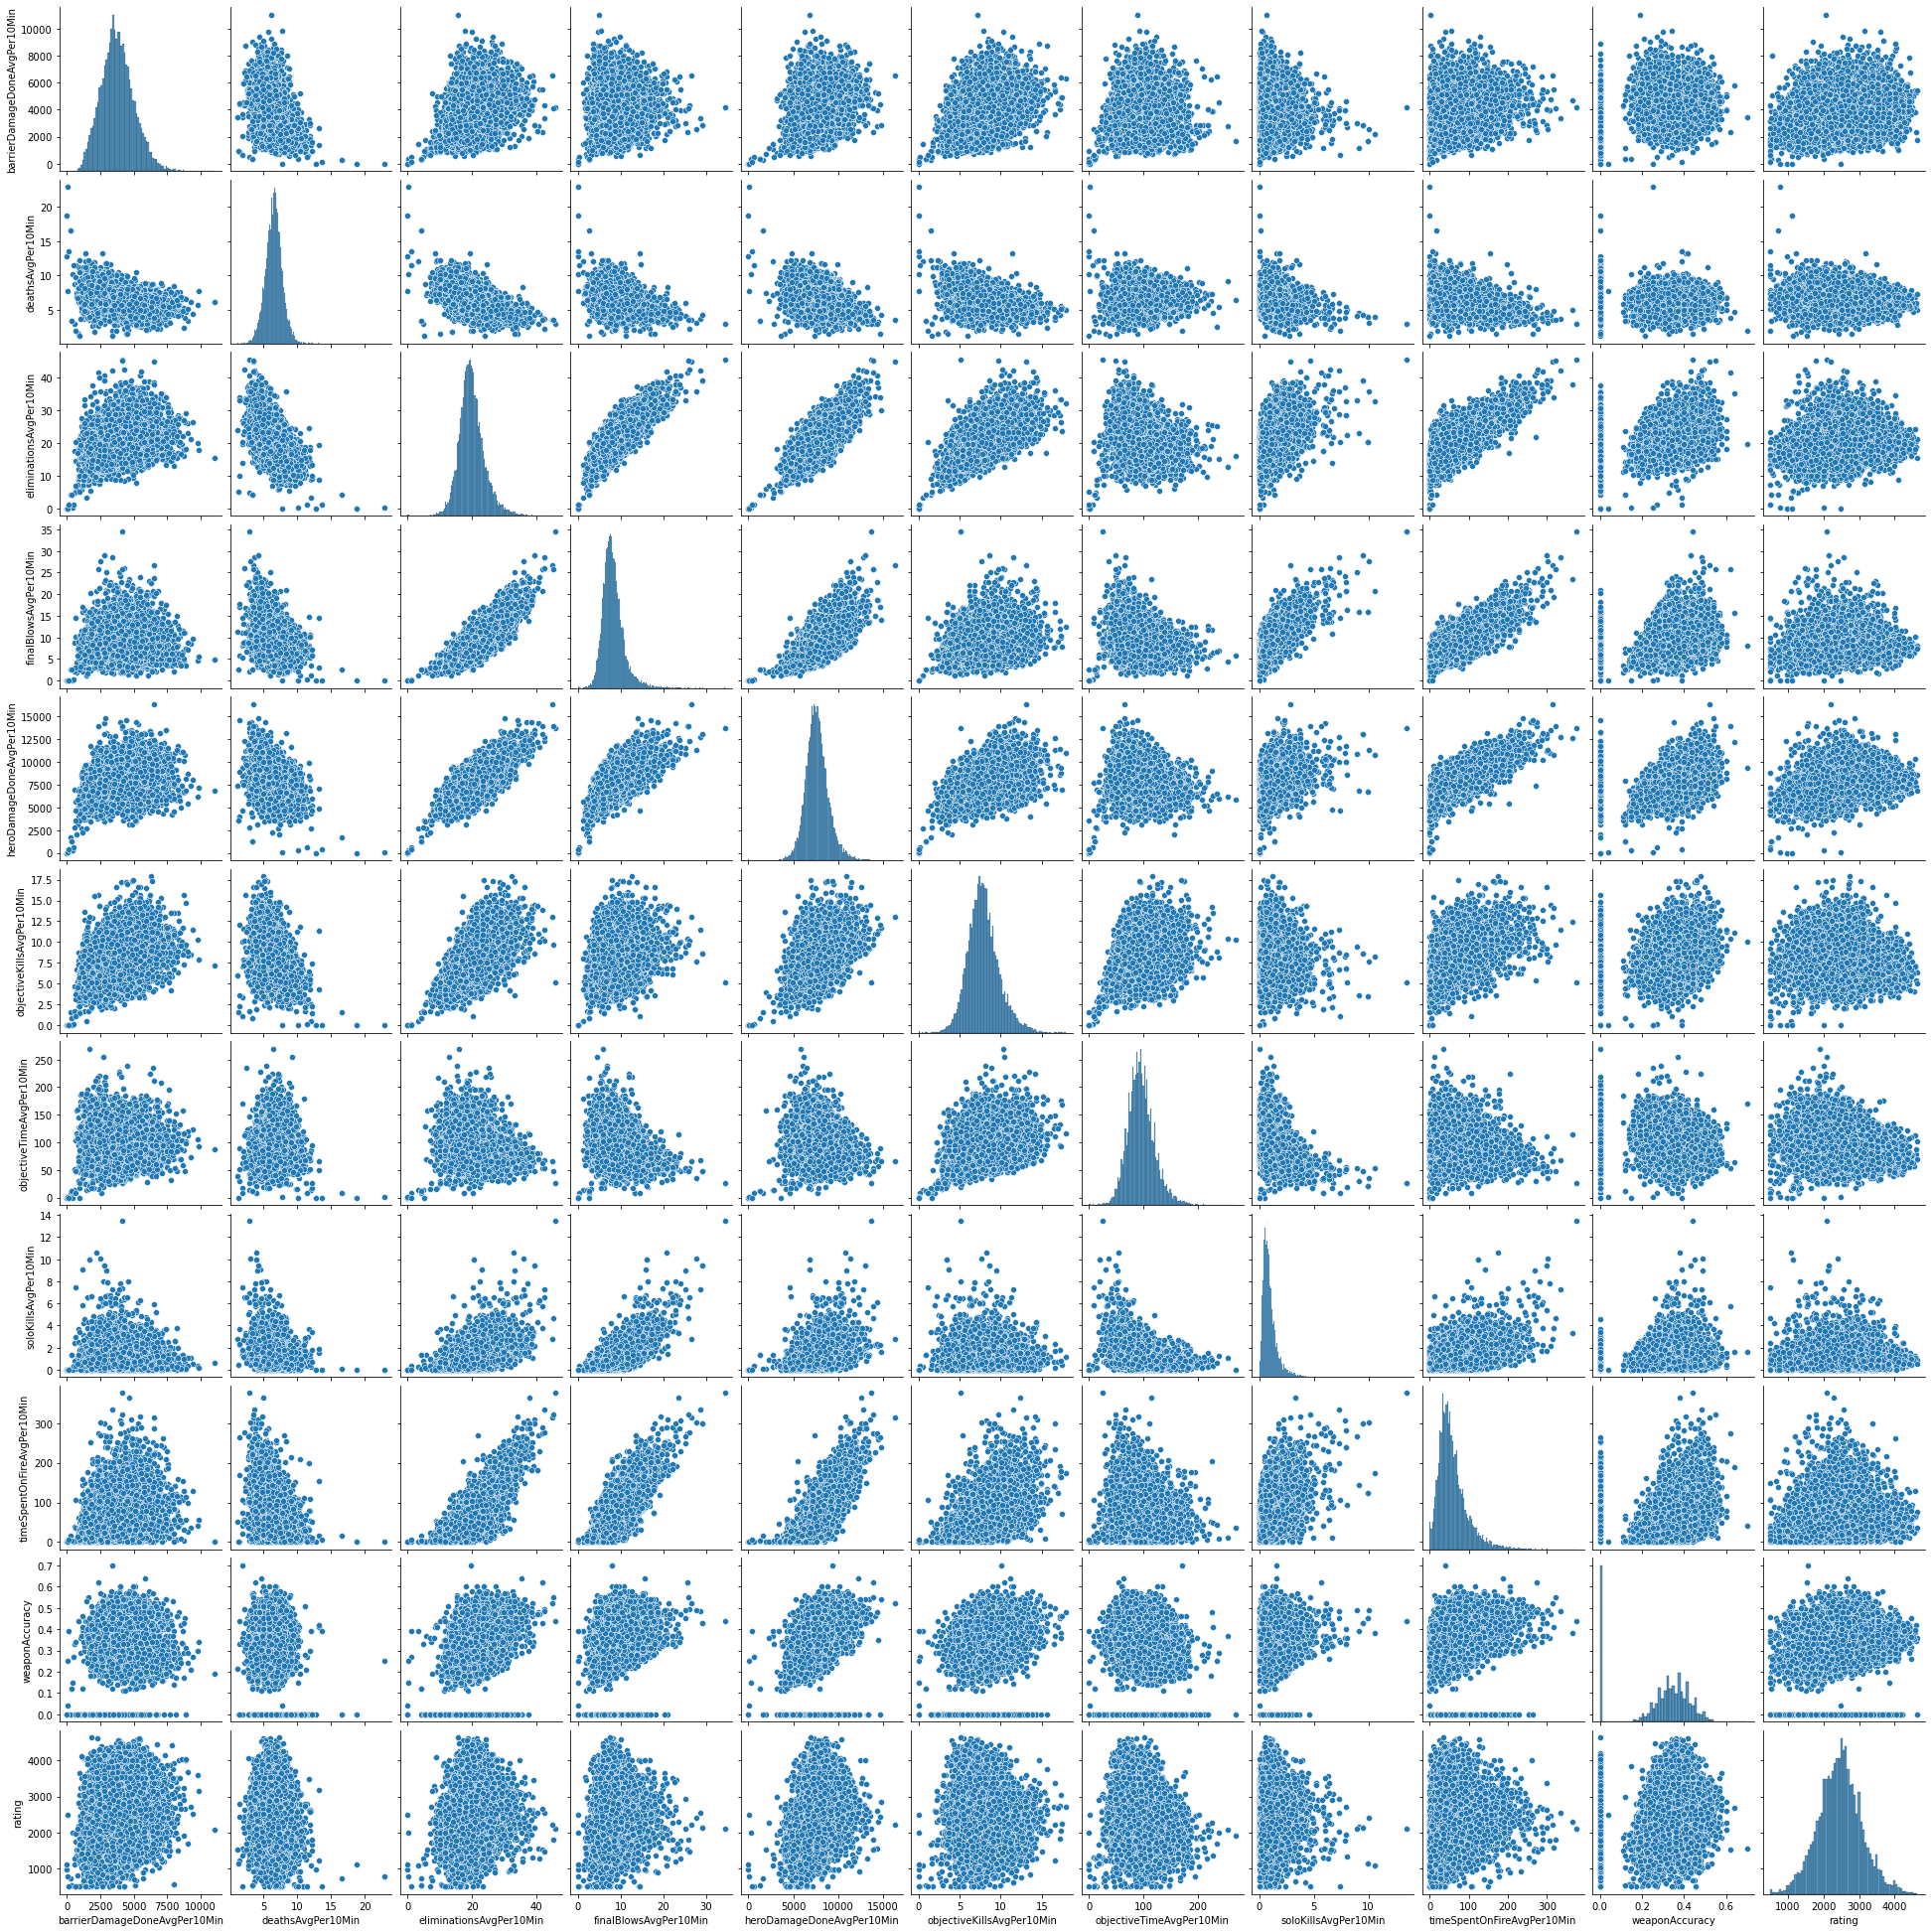

In [17]:
sns.pairplot(agg_df)

In [25]:
(agg_df.weaponAccuracy == 0).sum() / len(agg_df)

0.22096021611001965

In [18]:
agg_df.corr()

,barrierDamageDoneAvgPer10Min,deathsAvgPer10Min,eliminationsAvgPer10Min,finalBlowsAvgPer10Min,heroDamageDoneAvgPer10Min,objectiveKillsAvgPer10Min,objectiveTimeAvgPer10Min,soloKillsAvgPer10Min,timeSpentOnFireAvgPer10Min,weaponAccuracy,rating
barrierDamageDoneAvgPer10Min,1.000000,-0.459219,0.422478,0.087523,0.306579,0.386826,-0.085687,0.021546,0.244967,0.436298,0.222357
deathsAvgPer10Min,-0.459219,1.000000,-0.568433,-0.301358,-0.321826,-0.394975,0.105039,-0.253400,-0.309947,-0.358493,-0.100791
eliminationsAvgPer10Min,0.422478,-0.568433,1.000000,0.753271,0.735819,0.611105,-0.228957,0.475884,0.755324,0.417487,0.196760
finalBlowsAvgPer10Min,0.087523,-0.301358,0.753271,1.000000,0.703125,0.250886,-0.281626,0.718892,0.780607,0.129088,0.142972
heroDamageDoneAvgPer10Min,0.306579,-0.321826,0.735819,0.703125,1.000000,0.398209,-0.212815,0.313982,0.764733,0.202839,0.330074
objectiveKillsAvgPer10Min,0.386826,-0.394975,0.611105,0.250886,0.398209,1.000000,0.307719,-0.007000,0.485118,0.335032,-0.064599
objectiveTimeAvgPer10Min,-0.085687,0.105039,-0.228957,-0.281626,-0.212815,0.307719,1.000000,-0.385912,-0.120798,-0.249108,-0.276347
soloKillsAvgPer10Min,0.021546,-0.253400,0.475884,0.718892,0.313982,-0.007000,-0.385912,1.000000,0.456020,0.207158,-0.004972
timeSpentOnFireAvgPer10Min,0.244967,-0.309947,0.755324,0.780607,0.764733,0.485118,-0.120798,0.456020,1.000000,0.192169,0.102448
weaponAccuracy,0.436298,-0.358493,0.417487,0.129088,0.202839,0.335032,-0.249108,0.207158,0.192169,1.000000,0.159675


<AxesSubplot:>

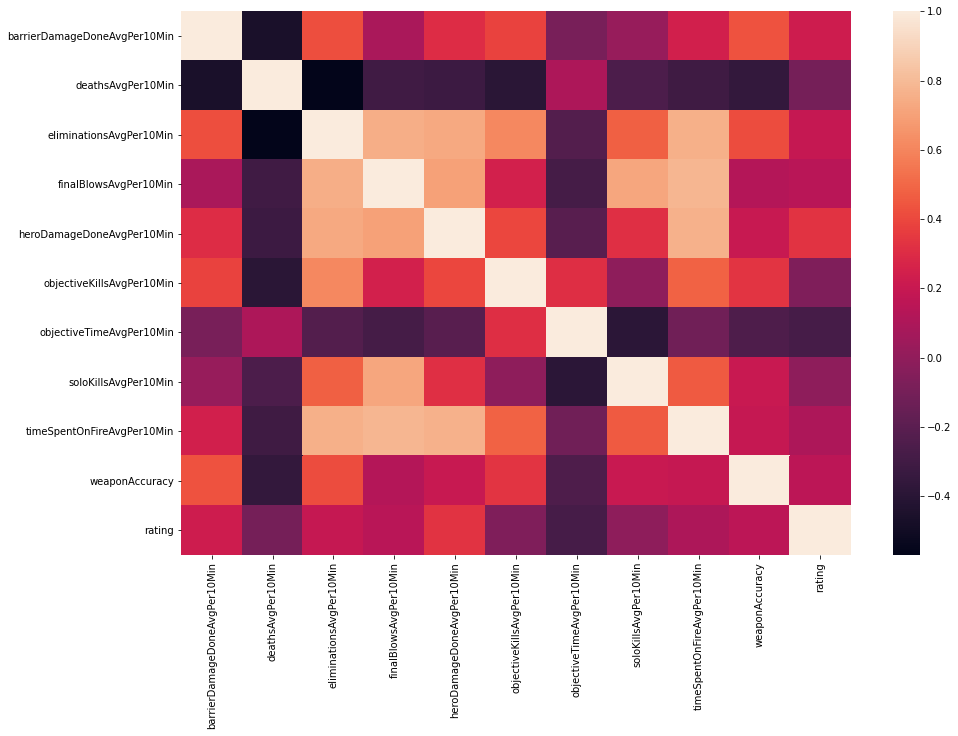

In [20]:
sns.heatmap(agg_df.corr())